# notebook for first single subject analysis and plotting - HCP 7t movie viewing

In [1]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nilearn.plotting as nlp
from nilearn_plotting_custom import plot_surf
import hcp_utils as hcp
from hcp_tools import extract_cortex
from hcp_tools import load_meshes
from hcp_tools import load_data
from hcp_tools import load_flatmaps_59k
from analysis import simple_ridgeCV

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### load subject data

In [101]:
subject=100610
feature='mfcc'
n_movies=4
X,Y,vertex_info = load_data(subject,feature,n_movies)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### run 5 fold ridgeCV, return mean scores and mean weights

In [104]:
scores_mean,weights_mean = simple_ridgeCV(X,Y)

In [106]:
np.save('../cache/temp_{feature}_scores_mean.npy',scores_mean)
np.save('../cache/temp_{feature}_weights_mean.npy',weights_mean)

In [3]:
# scores_mean = np.load('../cache/temp_scores_mean.npy')
# weights_mean = np.load('../cache/temp_weights_mean.npy')

### load flat maps for plotting

In [5]:
flatmeshes=load_flatmaps_59k()

In [13]:
#load other meshes
surf_path_msm = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.L.inflated_1.6mm_MSMAll.59k_fs_LR.surf.gii'
#surf_path_msm = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.L.inflated_1.6mm_MSMAll.59k_fs_LR.surf.gii'
mesh59k_msm = load_meshes(example_filename=surf_path_msm)

Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data


In [40]:
most_likely=np.argmax(weights_mean,axis=1)

In [51]:
alpha05 = np.where(scores_mean>0, scores_mean, 0)*2
alpha05 = np.where(alpha05>1, 1, alpha05) ### everything below 0 = 0 ; scale everything else 0:0.5 -> 0:1
alpha = np.where(scores_mean>0, scores_mean, 0)

In [66]:
#get cortex data from cut_scores output using the vertex_info
score_cortex_data = hcp.cortex_data(scores_mean, fill=0, vertex_info=vertex_info)
score_cortex_dataL = hcp.left_cortex_data(scores_mean, fill=0, vertex_info=vertex_info)
score_cortex_dataR = hcp.right_cortex_data(scores_mean, fill=0, vertex_info=vertex_info)

most_likely_cortex_data = hcp.cortex_data(most_likely, fill=0, vertex_info=vertex_info)
most_likely_cortex_dataL = hcp.left_cortex_data(most_likely, fill=0, vertex_info=vertex_info)
most_likely_cortex_dataR = hcp.right_cortex_data(most_likely, fill=0, vertex_info=vertex_info)

alpha05_cortex_data = hcp.cortex_data(alpha05, fill=0, vertex_info=vertex_info)
alpha05_cortex_dataL = hcp.left_cortex_data(alpha05, fill=0, vertex_info=vertex_info)
alpha05_cortex_dataR = hcp.right_cortex_data(alpha05, fill=0, vertex_info=vertex_info)

alpha_cortex_data = hcp.cortex_data(alpha, fill=0, vertex_info=vertex_info)
alpha_cortex_dataL = hcp.left_cortex_data(alpha, fill=0, vertex_info=vertex_info)
alpha_cortex_dataR = hcp.right_cortex_data(alpha, fill=0, vertex_info=vertex_info)

data_remove = np.where(scores_mean>0, 0, 1) # where there is data set to 0, elsewhere set to 1

In [78]:
sulc_left = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.L.sulc.59k_fs_LR.shape.gii'

[-0.53187069 -0.52338143 -0.49296844 ...  0.10467775  0.11040105
  0.1124212 ]


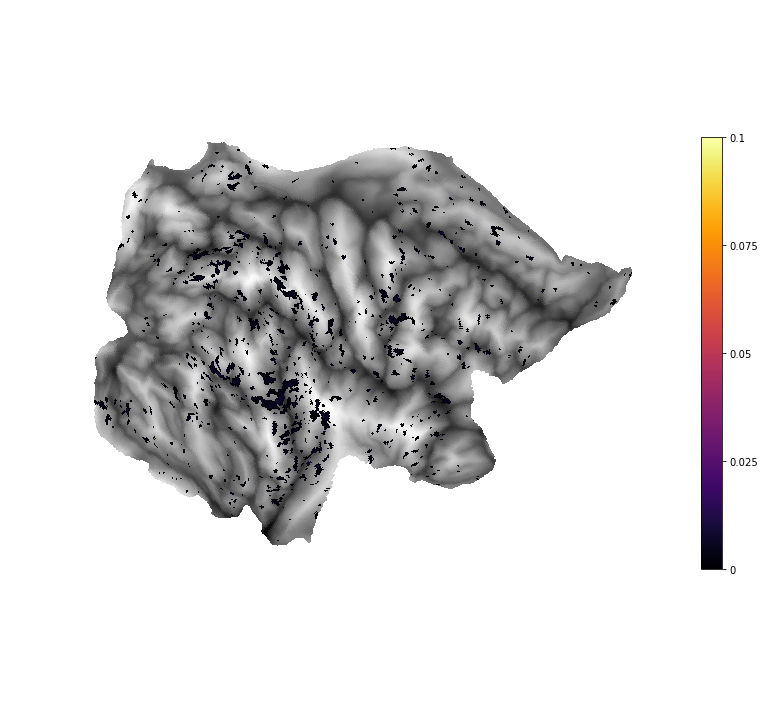

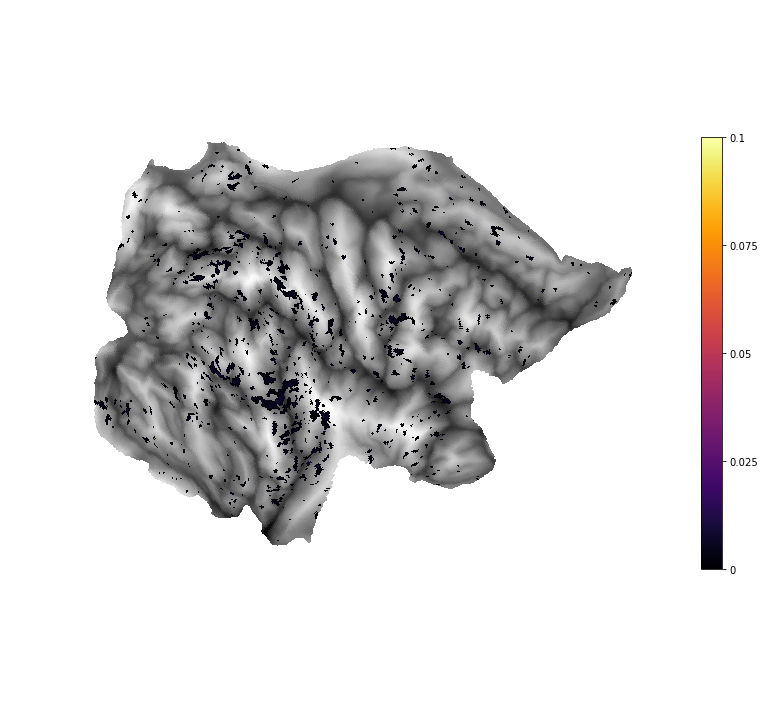

In [98]:
plot_surf(flatmeshes.flat_left,\
        score_cortex_dataL, \
          cmap='inferno',symmetric_cmap=False, avg_method='median',#figure=fig,\
        bg_map=sulc_left, colorbar=True, vmin=0, vmax=0.1, \
        data_alpha=np.where(score_cortex_dataL>0,1,0),\
        data_remove=np.zeros(data_alpha.shape))

[0.         0.00787402 0.01574803 0.02362205 0.03149606 0.03937008
 0.04724409 0.05511811 0.06299213 0.07086614 0.07874016 0.08661417
 0.09448819 0.1023622  0.11023622 0.11811024 0.12598425 0.13385827
 0.14173228 0.1496063  0.15748031 0.16535433 0.17322835 0.18110236
 0.18897638 0.19685039 0.20472441 0.21259843 0.22047244 0.22834646
 0.23622047 0.24409449 0.2519685  0.25984252 0.26771654 0.27559055
 0.28346457 0.29133858 0.2992126  0.30708661 0.31496063 0.32283465
 0.33070866 0.33858268 0.34645669 0.35433071 0.36220472 0.37007874
 0.37795276 0.38582677 0.39370079 0.4015748  0.40944882 0.41732283
 0.43307087 0.44094488 0.4488189  0.45669291 0.46456693 0.47244094
 0.48031496 0.48818898 0.51181102 0.52755906 0.53543307 0.54330709
 0.5511811  0.55905512 0.56692913 0.57480315 0.58267717 0.60629921
 0.61417323 0.62204724 0.62992126 0.64566929 0.65354331 0.66141732
 0.66929134 0.67716535 0.68503937 0.69291339 0.7007874  0.70866142
 0.71653543 0.72440945 0.73228346 0.74015748 0.7480315  0.7559

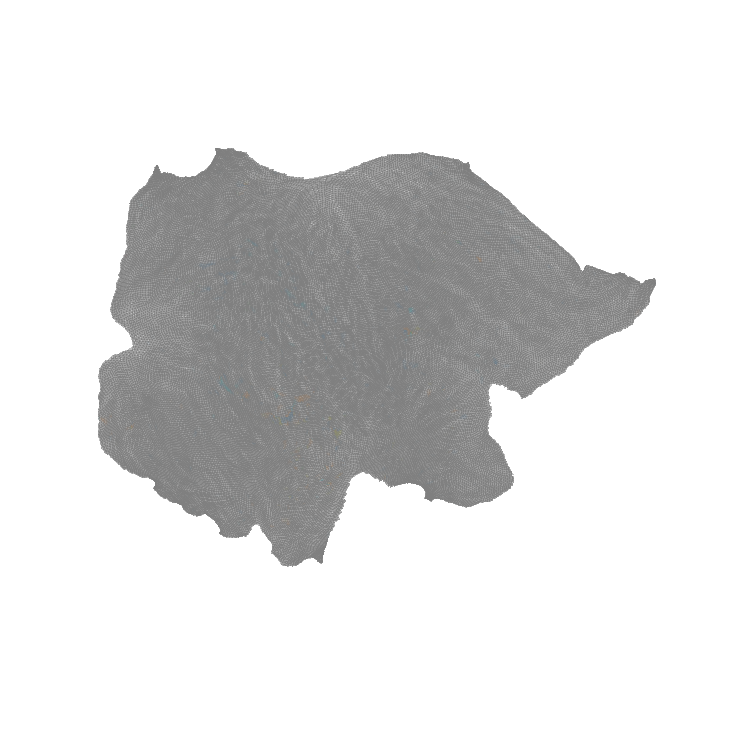

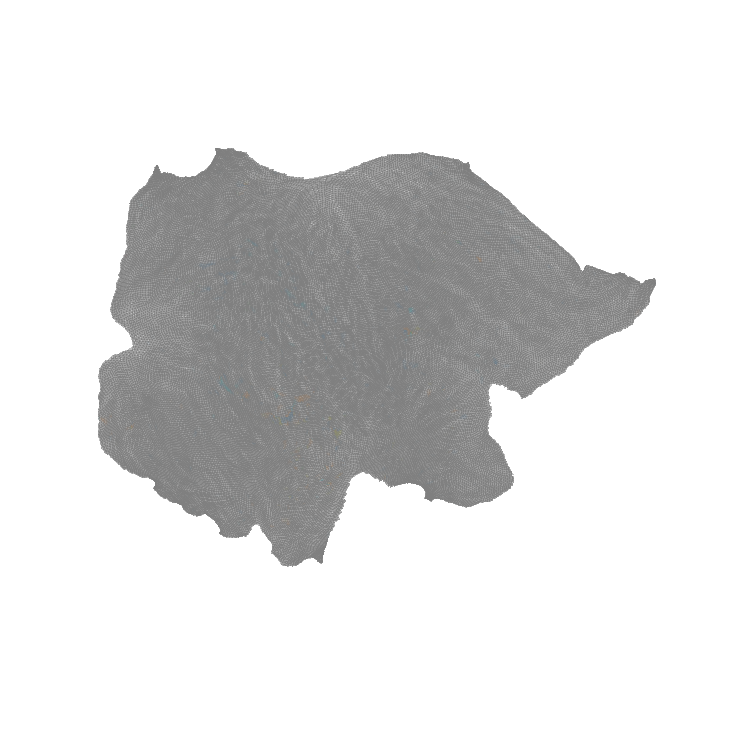

In [53]:
#plot weights with r2 *2 as the alpha - can't see anything
plot_surf(flatmeshes.flat_left,\
        most_likely_cortex_dataL, \
          cmap='tab10',symmetric_cmap=False, avg_method='median',#figure=fig,\
        bg_map=None,\
        data_alpha=alpha05_cortex_dataL,\
        data_remove=data_remove)

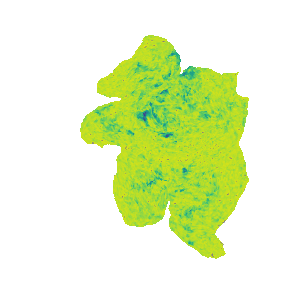

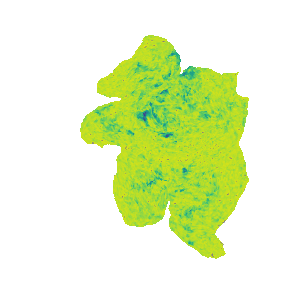

In [43]:
from nilearn import surface
coord, faces = surface.load_surf_mesh(surf_path_msm)
#nlp.view_surf(surf_path_msm,surf_map=cut_score_cortex_dataL,vmax=0.2,threshold=0.01)
nlp.plot_surf(mesh59k_msm.inflated_right,surf_map=cut_score_cortex_dataL,vmax=0.2,threshold=0.01,view='dorsal')

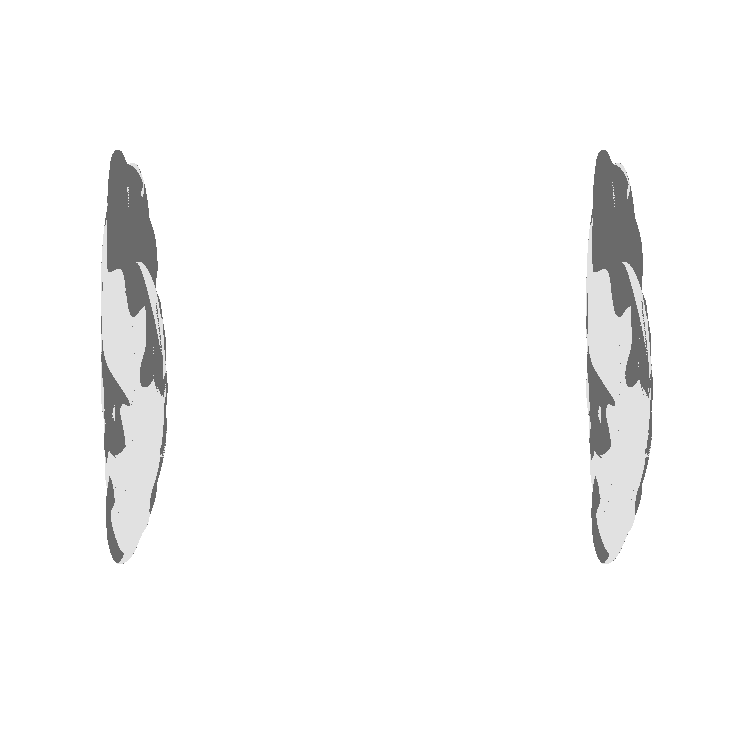

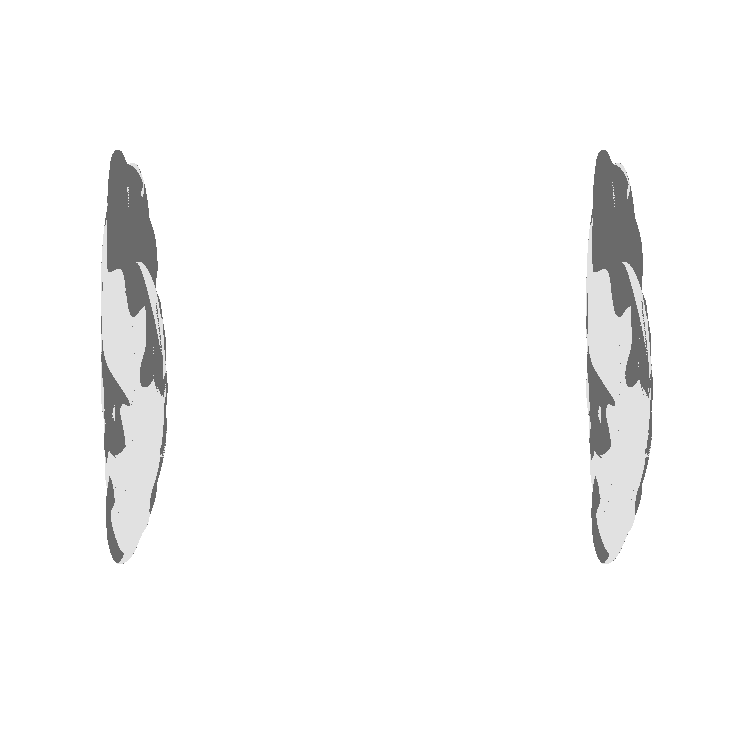

In [26]:
plot_surf(flatmeshes.flat)

In [ ]:
plot_surf(flatmeshes.flat_left,\
            hcp.cortex_data(cut_score_new), cmap='viridis',symmetric_cmap=False, vmin=0, vmax=0.25, colorbar=True,avg_method='median',#figure=fig,\
            bg_map=hcp.mesh.sulc,title=f'title',\
            data_alpha=hcp.cortex_data(np.ones(cut_score_new.shape)),#np.ones(data_alpha05.shape)),\
            data_remove=hcp.cortex_data(data_remove))

In [16]:
# load a 59k flatmap


In [38]:
from hcp_tools import load_flatmaps_59k

ImportError: cannot import name 'load_flatmaps_59k' from 'hcp_tools' (/om2/vast/gablab/jsmentch/projects/nat_img/code/hcp_tools.py)

In [34]:
meshes.flat

(array([[   0.      , -115.62291 ,  169.59259 ],
        [   0.      , -190.34683 ,  123.08588 ],
        [   0.      , -255.30742 ,   44.712387],
        ...,
        [   0.      ,  365.4124  ,  -26.98692 ],
        [   0.      ,  364.5382  ,  -26.791899],
        [   0.      ,  365.91803 ,  -25.534286]], dtype=float32),
 array([[    12,      0,     88],
        [    12,     88,    240],
        [    13,     12,    240],
        ...,
        [118583,  98254,  74542],
        [ 74543, 118583,  74542],
        [ 74542,  98254,  59301]], dtype=int32))

In [37]:
def test():
    from nilearn import surface
    from sklearn.utils import Bunch
    surf_path_msm = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.L.inflated_1.6mm_MSMAll.59k_fs_LR.surf.gii'
    meshes = Bunch()
    for hemisphere, hemisphere_name in [('L', 'left'), ('R', 'right')]:
        coord, faces = surface.load_surf_mesh(surf_path_msm)
        coordnew = np.zeros_like(coord)
        coordnew[:, 1] = coord[:, 0]
        coordnew[:, 2] = coord[:, 1]
        coordnew[:, 0] = 0
        coord = coordnew
        meshes['flat'+'_'+hemisphere_name] = coord, faces
    coordl, facesl = meshes['flat_left']
    coordr, facesr = meshes['flat_right']
    coordlnew = coordl.copy()
    coordlnew[:, 1] = coordl[:, 1] - 250.0
    coordrnew = coordr.copy()
    coordrnew[:, 1] = coordr[:, 1] + 250.0
    meshes['flat'] = hcp.combine_meshes( (coordlnew, facesl), (coordrnew, facesr) )
    return meshes

In [ ]:
X = img.get_fdata() #load data from nii
X_t = X[17:] #trim beginning, first 17 TRs
Ybrain = X_t[:1009] #trim end to end of film    braintrain.append(s_brain[:-200,:]) #roughly 80 20 split, trim the last 200 TRs of each subject to save as test set
Ybrain = Ybrain[:,union_ind_ind[0]]
#     Ybrain_train = s_brain[:-200,:]
#     Ybrain_test = s_brain[-200:,:]
#as in https://nilearn.github.io/auto_examples/02_decoding/plot_miyawaki_encoding.html#sphx-glr-auto-examples-02-decoding-plot-miyawaki-encoding-py
Ybrain = np.nan_to_num(Ybrain)
estimator = RidgeCV(alphas=[0.1, 1.0, 10.0, 100])
cv = KFold(n_splits=5)
scores = []
for train, test in cv.split(X=X_as):
    train = train[2:-2] #remove the first and last 3 seconds of each test and train partition
    test = test[2:-2]
    #print('train, test')
    # we train the Ridge estimator on the training set
    # and predict the fMRI activity for the test set
    predictions = estimator.fit(X_as.reshape(-1, X_as.shape[1])[train], Ybrain[train]).predict(
        X_as.reshape(-1, X_as.shape[1])[test])
    # we compute how much variance our encoding model explains in each voxel
    scores.append(r2_score(Ybrain[test], predictions,
                           multioutput='raw_values'))
cut_score = np.mean(scores, axis=0)
#cut_score[cut_score < 0] = 0

cut_score_new = np.zeros((union_ind.shape[0]))
for i,ind in enumerate(union_ind_ind[0]):
    cut_score_new[ind]=cut_score[i]
all_scores.append(cut_score_new)
#make a temp valid cifti2img
#temp_img = nb.Cifti2Image(cut_score.reshape((1,91282)), img.header)
plot_surf(hcp.mesh.flat,\
    hcp.cortex_data(cut_score_new), cmap='viridis',symmetric_cmap=False, vmin=0, vmax=0.25, colorbar=True,avg_method='median',#figure=fig,\
    bg_map=hcp.mesh.sulc,title=f'voxel-wise Encoding Model, R2 {sub} 5-fold cv {featname}',\
    data_alpha=hcp.cortex_data(np.ones(cut_score_new.shape)),#np.ones(data_alpha05.shape)),\
    data_remove=hcp.cortex_data(data_remove),output_file=f'2021_02_05_low_level/{sub}-{featname}_ridgecv.png')
#plot_dscalar(temp_img, title=f'voxel-wise Encoding Model, R2 {sub} 5-fold cv {featname}',colorbar=True, vmin=0, vmax=1, plot_abs=False, threshold=None, cmap='bwr', output_file=f'2021_02_05_low_level/{sub}-{featname}_ridgecv.png')
all_scores=np.asarray(all_scores)
all_scores_mean=np.mean(all_scores,axis=0)
plot_surf(hcp.mesh.flat,\
hcp.cortex_data(all_scores_mean), cmap='viridis',symmetric_cmap=False, vmin=0, vmax=0.25, colorbar=True,avg_method='median',#figure=fig,\
bg_map=hcp.mesh.sulc,title=f'voxel-wise Encoding Model, R2 {sub} 5-fold cv {featname}',\
data_alpha=hcp.cortex_data(np.ones(cut_score_new.shape)),#np.ones(data_alpha05.shape)),\
data_remove=hcp.cortex_data(data_remove),output_file=f'2021_02_05_low_level/all-{featname}_ridgecv.png')

## 